In [1]:
print(sc.uiWebUrl)

http://midway3-0113.rcc.local:4041


In [2]:
! squeue -u yjia2

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          42207388   caslake _interac    yjia2  R       4:08      1 midway3-0113


In [3]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "/home/yjia2/fonts/NotoSansCJKsc-Regular.otf"  
fm.fontManager.addfont(font_path)
zh_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = zh_font.get_name()
plt.rcParams["axes.unicode_minus"] = False

In [12]:
from gensim.models.coherencemodel import CoherenceModel
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import functions as F
from pyspark.ml.clustering import LDA
from gensim import corpora


# Investigate the Method's Current Usage

In [6]:
# Pre-processing

BASE_PATH = "cleaned_segmented_parquet"

df_raw = spark.read.parquet(BASE_PATH)

df = (
    df_raw
    .withColumnRenamed("文本内容_清洗", "content_cleaned")
    .withColumnRenamed("年份", "year")
    .select("content_cleaned", "year")
)

df = df.withColumn("year", F.col("year").cast("int"))

df = (
    df
    .withColumn("content_cleaned", F.trim(F.col("content_cleaned")))
    .filter(
        F.col("content_cleaned").isNotNull()
        & (F.length("content_cleaned") > 0)
    )
)

df = (
    df
    .withColumn("tokens", F.split(F.col("content_cleaned"), r"\s+"))
    .withColumn("tokens", F.expr("filter(tokens, x -> x <> '')"))
)

df = (
    df
    .withColumn("len_tokens", F.size("tokens"))
    .filter(F.col("len_tokens") >= 3)
    .drop("len_tokens")
)

year_stats = (
    df.groupBy("year")
      .agg(
          F.count("*").alias("n_docs"),
          F.sum(F.size("tokens")).alias("n_tokens")
      )
      .orderBy("year")
)

year_stats.show(1, truncate=False)


+----+------+--------+
|year|n_docs|n_tokens|
+----+------+--------+
|1947|10769 |2711874 |
+----+------+--------+
only showing top 1 row



In [7]:
MIN_YEAR = 1949
MAX_YEAR = 2024

MIN_TOKENS = 5  

df_lda = (
    df
    .filter((F.col("year") >= MIN_YEAR) & (F.col("year") <= MAX_YEAR))
    .withColumn("token_len", F.size("tokens"))
    .filter(F.col("token_len") >= MIN_TOKENS)
    .select("year", "tokens")
)

df_lda = df_lda.repartition(200).cache()
n_docs = df_lda.count()
print("Docs for LDA:", n_docs)

[Stage 8:=====================================================> (193 + 7) / 200]

Docs for LDA: 1985873


In [11]:
VOCAB_MIN_DF = 30   
VOCAB_SIZE   = 20000   

cv = CountVectorizer(
    inputCol="tokens",
    outputCol="features",
    vocabSize=VOCAB_SIZE,
    minDF=VOCAB_MIN_DF
)

cv_model = cv.fit(df_lda)
df_vec = cv_model.transform(df_lda).select("year", "features")

len(cv_model.vocabulary)
df_vec.show(1, truncate=False)

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|year|features                                                                                                                                                                                                                    |
+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2010|(20000,[0,6,7,18,26,44,54,61,62,78,263,265,376,547,610,1129,1172,1613,1867,2211,2661,4706,9864,12074,14956,18887],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0])|
+----+----------------------------------------------------------------------------------

In [13]:
NUM_TOPICS = 50      
MAX_ITER  = 50      
SEED      = 42

lda = LDA(
    k=NUM_TOPICS,
    maxIter=MAX_ITER,
    featuresCol="features",
    topicDistributionCol="topicDistribution",
    seed=SEED
)

print("Fitting LDA model…")
lda_model = lda.fit(df_vec)
print("LDA model trained.")


Fitting LDA model…


25/11/19 16:25:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/11/19 16:25:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


[Stage 286:====================================================>(199 + 1) / 200]

LDA model trained.


In [51]:
MODEL_DIR = "lda50_model"

# 1) Save CountVectorizer
cv_model.write().overwrite().save(f"{MODEL_DIR}/cv_model")
print("Saved CountVectorizer model.")

# 2) Save LDA model
lda_model.write().overwrite().save(f"{MODEL_DIR}/lda_model")
print("Saved LDA model.")

# 3) Save metadata
import json
metadata = {
    "k": 50,
    "minDF": 30,
    "vocabSize": 20000,
    "maxIter": 50,
    "seed": 42
}

with open(f"{MODEL_DIR}/metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Saved metadata.")


Saved CountVectorizer model.
25/11/19 17:28:35 WARN TaskSetManager: Stage 588 contains a task of very large size (7978 KiB). The maximum recommended task size is 1000 KiB.
Saved LDA model.
Saved metadata.


In [15]:
topics = lda_model.describeTopics(maxTermsPerTopic=15)

topics.show(5, truncate=False)


+-----+----------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                                       |termWeights                                                                                                                                                                                                                                                                                                                                |
+-----+----------------------------------------------------------------------------------+----------------------------------------------------------------

In [16]:
vocab = cv_model.vocabulary  # list[str]

def indices_to_words(idxs):
    return [vocab[i] for i in idxs]

idxs_to_words_udf = F.udf(indices_to_words)

topics_words = topics.withColumn(
    "termWords",
    idxs_to_words_udf(F.col("termIndices"))
)

topics_words.select("topic", "termWords", "termWeights").show(10, truncate=False)


[Stage 288:>                                                        (0 + 1) / 1]

+-----+------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termWords                                                                                 |termWeights                                                                                                                                                                                                                                                                                                                                |
+-----+------------------------------------------------------------------------------------------+----------------------------------------

In [17]:
topics_local = (
    topics_words
    .select("topic", "termWords")
    .orderBy("topic")
    .collect()
)

topic_word_lists = []
for row in topics_local:
    topic_word_lists.append(row["termWords"])

print(f"Number of topics: {len(topic_word_lists)}")
print("Example of topic 0 words:", topic_word_lists[0][:20])


Number of topics: 50
Example of topic 0 words: [干部, 工作, 群众, 领导, 党员,


In [18]:
SAMPLE_FRACTION = 0.02   
MAX_DOCS        = 50000  

df_sample = (
    df_lda
    .sample(withReplacement=False, fraction=SAMPLE_FRACTION, seed=42)
    .select("tokens")
    .limit(MAX_DOCS)
)

n_sample = df_sample.count()
print("Docs sampled for coherence:", n_sample)

sample_rows = df_sample.collect()
texts = [row["tokens"] for row in sample_rows]

print("Example text:", texts[0][:30])


Docs sampled for coherence: 39687
Example text: ['特别', '生日', '月', '日', '中午', '安徽', '池州', '东至县', '沼潭', '敬老院', '贺', '学文', '右', '三', '老人', '迎来', '岁', '生日', '院长', '左一', '老人', '点燃', '生日', '蜡烛', '据悉', '东至县', '实施', '供养', '五保', '老人']


In [19]:
%pip install gensim


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
dictionary = corpora.Dictionary(texts)

print("Dictionary size:", len(dictionary))
print("Example token to id:", list(dictionary.items())[:10])


Dictionary size: 321984
Example token to id: [(0, '三'), (1, '东至县'), (2, '中午'), (3, '五保'), (4, '供养'), (5, '县内'), (6, '右'), (7, '夕阳红'), (8, '学文'), (9, '安徽')]


In [22]:
coh_model = CoherenceModel(
    topics=topic_word_lists,   # list of list of words
    texts=texts,               # token list
    dictionary=dictionary,     
    coherence='c_v'
)

coherence_scores = coh_model.get_coherence_per_topic()
overall_coherence = coh_model.get_coherence()

print("Coherence per topic:")
for i, score in enumerate(coherence_scores):
    print(f"Topic {i}: {score:.4f}")

print("\nOverall C_v coherence:", overall_coherence)


Coherence per topic:
Topic 0: 0.4123
Topic 1: 0.3427
Topic 2: 0.2774
Topic 3: 0.2122
Topic 4: 0.2057
Topic 5: 0.2879
Topic 6: 0.3134
Topic 7: 0.2530
Topic 8: 0.3169
Topic 9: 0.3045
Topic 10: 0.2098
Topic 11: 0.2455
Topic 12: 0.2336
Topic 13: 0.2804
Topic 14: 0.2913
Topic 15: 0.2713
Topic 16: 0.2693
Topic 17: 0.2640
Topic 18: 0.3007
Topic 19: 0.4542
Topic 20: 0.3185
Topic 21: 0.2283
Topic 22: 0.3036
Topic 23: 0.2929
Topic 24: 0.2281
Topic 25: 0.3289
Topic 26: 0.3805
Topic 27: 0.3211
Topic 28: 0.2020
Topic 29: 0.2565
Topic 30: 0.2323
Topic 31: 0.3334
Topic 32: 0.2821
Topic 33: 0.3825
Topic 34: 0.2120
Topic 35: 0.3142
Topic 36: 0.3324
Topic 37: 0.2227
Topic 38: 0.3383
Topic 39: 0.2968
Topic 40: 0.3978
Topic 41: 0.3632
Topic 42: 0.3677
Topic 43: 0.2999
Topic 44: 0.4289
Topic 45: 0.3124
Topic 46: 0.2359
Topic 47: 0.2920
Topic 48: 0.2587
Topic 49: 0.2535

Overall C_v coherence: 0.2952573673359303


In [47]:
THRESHOLD = 0.4

good_topics_1 = [i for i, s in enumerate(coherence_scores) if s >= THRESHOLD]

print("Good topics in first LDA (K=50):", good_topics_1)
print("-" * 60)

for i in good_topics_1:
    words = topic_word_lists[i][:1000]
    print(f"Topic {i} | coherence = {coherence_scores[i]:.4f}")
    print("Top words:", " ".join(words))
    print("-" * 60)


Good topics in first LDA (K=50): [0, 19, 44]
------------------------------------------------------------
Topic 0 | coherence = 0.4123
Top words: [ 干 部 ,   工 作 ,   群 众 ,   领 导 ,   党 员 ,   基 层 ,   不 ,   制 度 ,   解 决 ,   监 督 ,   中 ,   扶 贫 ,   组 织 ,   党 组 织 ,   部 门 ]
------------------------------------------------------------
Topic 19 | coherence = 0.4542
Top words: [ 说 ,   都 ,   不 ,   上 ,   人 ,   一 个 ,   去 ,   里 ,   还 ,   时 ,   好 ,   后 ,   很 ,   想 ,   走 ]
------------------------------------------------------------
Topic 44 | coherence = 0.4289
Top words: [ 学 生 ,   教 育 ,   学 校 ,   教 师 ,   学 习 ,   大 学 ,   教 学 ,   工 作 ,   培 养 ,   中 ,   孩 子 ,   小 学 ,   老 师 ,   儿 童 ,   学 院 ]
------------------------------------------------------------


In [23]:
# Rebuild CountVectorizer with new hyperparams 
NEW_VOCAB_SIZE = 15000   
NEW_MIN_DF     = 80     

cv2 = CountVectorizer(
    inputCol="tokens",
    outputCol="features",
    vocabSize=NEW_VOCAB_SIZE,
    minDF=NEW_MIN_DF
)

print("Fitting new CountVectorizer...")
cv2_model = cv2.fit(df_lda)

print("Vocab size (actual):", len(cv2_model.vocabulary))

print("Transforming df_lda to count vectors...")
df_vec2 = cv2_model.transform(df_lda).select("year", "features")

# Train new LDA model 
NEW_NUM_TOPICS = 30
MAX_ITER       = 50
SEED           = 42

lda2 = LDA(
    k=NEW_NUM_TOPICS,
    maxIter=MAX_ITER,
    featuresCol="features",
    topicDistributionCol="topicDistribution",
    seed=SEED
)

print("Fitting new LDA model...")
lda2_model = lda2.fit(df_vec2)
print("New LDA model trained.")

# Extract topics with top words
topics2 = lda2_model.describeTopics(maxTermsPerTopic=15)

# map termIndices -> termWords using new vocabulary
vocab2 = cv2_model.vocabulary  # list[str]

def indices_to_words2(idxs):
    return [vocab2[i] for i in idxs]

idxs_to_words_udf2 = F.udf(indices_to_words2)

topics2_words = topics2.withColumn(
    "termWords",
    idxs_to_words_udf2(F.col("termIndices"))
)

topics2_words.select("topic", "termWords", "termWeights").show(10, truncate=False)

# Collect topic -> word lists for coherence computation
topics2_local = (
    topics2_words
    .select("topic", "termWords")
    .orderBy("topic")
    .collect()
)

topic2_word_lists = [row["termWords"] for row in topics2_local]
print("Number of topics:", len(topic2_word_lists))
print("Example topic 0 words:", topic2_word_lists[0][:20])


Fitting new CountVectorizer...


Vocab size (actual): 15000
Transforming df_lda to count vectors...
Fitting new LDA model...


New LDA model trained.
+-----+------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termWords                                                                                       |termWeights                                                                                                                                                                                                                                                                                                                                |
+-----+------------------------------------------------------------------------------------------------

In [24]:
dictionary2 = corpora.Dictionary(texts)
print("Dictionary2 size:", len(dictionary2))

# Coherence model for new topics
coh_model2 = CoherenceModel(
    topics=topic2_word_lists,
    texts=texts,
    dictionary=dictionary2,
    coherence='c_v'
)

coherence_scores2 = coh_model2.get_coherence_per_topic()
overall_coherence2 = coh_model2.get_coherence()

print("New coherence per topic:")
for i, score in enumerate(coherence_scores2):
    print(f"Topic {i}: {score:.4f}")

print("\nNew overall C_v coherence:", overall_coherence2)


Dictionary2 size: 321984
New coherence per topic:
Topic 0: 0.3171
Topic 1: 0.3272
Topic 2: 0.3306
Topic 3: 0.2794
Topic 4: 0.2826
Topic 5: 0.2472
Topic 6: 0.2665
Topic 7: 0.2808
Topic 8: 0.2572
Topic 9: 0.2142
Topic 10: 0.3818
Topic 11: 0.1927
Topic 12: 0.2670
Topic 13: 0.2873
Topic 14: 0.3176
Topic 15: 0.2880
Topic 16: 0.3014
Topic 17: 0.3054
Topic 18: 0.2504
Topic 19: 0.3138
Topic 20: 0.2693
Topic 21: 0.2516
Topic 22: 0.2613
Topic 23: 0.2359
Topic 24: 0.2901
Topic 25: 0.1786
Topic 26: 0.3920
Topic 27: 0.4289
Topic 28: 0.2264
Topic 29: 0.3848

New overall C_v coherence: 0.28756545246889426


In [45]:
THRESHOLD = 0.35

good_topics_2 = [i for i, s in enumerate(coherence_scores2) if s >= THRESHOLD]

print("Good topics in second LDA (K=30):", good_topics_2)
print("-" * 60)

for i in good_topics_2:
    words = topic2_word_lists[i][:1000]    
    print(f"Topic {i} | coherence = {coherence_scores2[i]:.4f}")  
    print("Top words:", " ".join(words))
    print("-" * 60)


Good topics in second LDA (K=30): [10, 26, 27, 29]
------------------------------------------------------------
Topic 10 | coherence = 0.3818
Top words: [ 市 场 ,   企 业 ,   服 务 ,   公 司 ,   不 ,   月 ,   消 费 者 ,   产 品 ,   消 费 ,   价 格 ,   管 理 ,   经 营 ,   年 ,   信 息 ,   西 藏 ]
------------------------------------------------------------
Topic 26 | coherence = 0.3920
Top words: [ 革 命 ,   毛 主 席 ,   无 产 阶 级 ,   中 ,   社 会 主 义 ,   群 众 ,   斗 争 ,   思 想 ,   资 产 阶 级 ,   学 习 ,   路 线 ,   毛 泽 东 思 想 ,   上 ,   批 判 ,   不 ]
------------------------------------------------------------
Topic 27 | coherence = 0.4289
Top words: [ 人 ,   上 ,   都 ,   一 个 ,   不 ,   说 ,   中 ,   里 ,   去 ,   还 ,   时 ,   很 ,   却 ,   会 ,   生 活 ]
------------------------------------------------------------
Topic 29 | coherence = 0.3848
Top words: [ 教 育 ,   学 生 ,   学 校 ,   人 才 ,   教 师 ,   学 习 ,   工 作 ,   培 养 ,   大 学 ,   年 ,   中 ,   教 学 ,   培 训 ,   社 会 ,   高 校 ]
------------------------------------------------------------


In [48]:
df_topics = lda_model.transform(df_vec)  

df_topics.printSchema()

root
 |-- year: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [49]:
df_topics = df_topics.withColumn(
    "topicDistArr",
    vector_to_array("topicDistribution")
)

# Topic 0 probability for each document
df_topics = df_topics.withColumn(
    "topic0_prob",
    F.col("topicDistArr")[0]   
)

df_topics.select("year", "topic0_prob").show(5)


25/11/19 17:23:20 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
+----+--------------------+
|year|         topic0_prob|
+----+--------------------+
|2010|6.284069282106592E-4|
|2010|1.908488692291569...|
|2010|3.570937647612526...|
|2010|4.056973684827297E-4|
|2010|6.444546884130569E-5|
+----+--------------------+
only showing top 5 rows



In [50]:
# Average Topic 0 proportion per year
topic0_by_year = (
    df_topics
    .groupBy("year")
    .agg(F.avg("topic0_prob").alias("topic0_mean"))
    .orderBy("year")
)

topic0_by_year.show(20)  


25/11/19 17:23:30 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


[Stage 579:====================================================>(199 + 1) / 200]

25/11/19 17:28:16 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
+----+--------------------+
|year|         topic0_mean|
+----+--------------------+
|1949|0.004898609568138073|
|1950|0.006417099305068968|
|1951|0.005243347844058094|
|1952|0.004401647068664121|
|1953|0.007993544881812744|
|1954|0.003878207728990...|
|1955|0.003650539007813393|
|1956|0.005586821523420855|
|1957|0.007924042346559641|
|1958| 0.00287916607518368|
|1959|0.002284357492768...|
|1960|0.003165668347323...|
|1961|0.003513099048711355|
|1962|0.001817055786492...|
|1963|0.001299557238234...|
|1964|0.001648558353322...|
|1965|0.001076537200053...|
|1966|0.001447346591520...|
|1967|0.001065127569768...|
|1968|0.001258059611991...|
+----+--------------------+
only showing top 20 rows



25/11/19 17:29:23 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


[Stage 592:====================================================>(198 + 2) / 200]

25/11/19 17:34:10 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/11/19 17:34:10 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


25/11/19 17:34:10 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


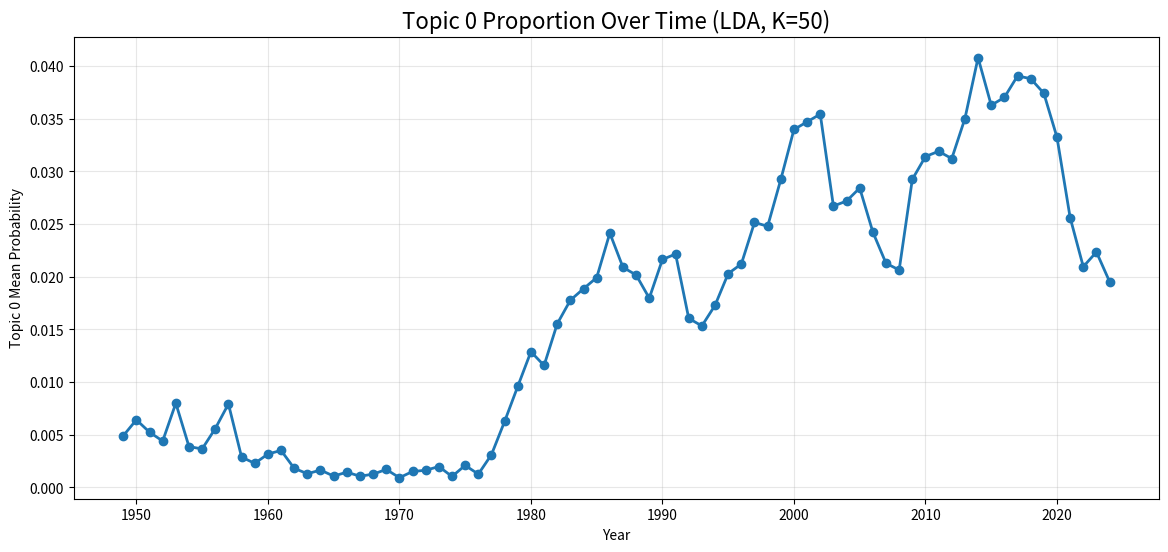

In [52]:
topic0_pd = topic0_by_year.toPandas()

topic0_pd = topic0_pd.sort_values("year")

plt.figure(figsize=(14, 6))
plt.plot(topic0_pd["year"], topic0_pd["topic0_mean"], marker="o", linewidth=2)

plt.title("Topic 0 Proportion Over Time (LDA, K=50)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Topic 0 Mean Probability")
plt.grid(True, alpha=0.3)

plt.show()
